# Modeling a Roman Microlensing Event lightcurve

This example uses simulated photometry from the [Microlensing Data Challenge](https://github.com/microlensing-data-challenge/data-challenge-1) and follows the modeling procedure for PyLIMA outlined [here](https://github.com/ebachelet/pyLIMA/blob/master/examples/pyLIMA_example_1.ipynb).    

In [43]:
from os import path
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from astropy import units as unit

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model, FSBL_model, USBL_model, pyLIMA_fancy_parameters
from pyLIMA.fits import DE_fit
from pyLIMA.fits import TRF_fit, DE_fit
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA import toolbox

# Configuration
data_dir = './data/'

Read in the simulated lightcurve data.

In [2]:
lc_file = 'ulwdc1_100_W149.txt'

data = np.loadtxt(path.join(data_dir, lc_file))
data

array([[2.45834651e+06, 2.38285970e+01, 4.67270000e-02],
       [2.45834652e+06, 2.38451080e+01, 4.74430000e-02],
       [2.45834653e+06, 2.38670280e+01, 4.84110000e-02],
       ...,
       [2.46005922e+06, 2.37240790e+01, 4.24390000e-02],
       [2.46005923e+06, 2.37928580e+01, 4.52140000e-02],
       [2.46005924e+06, 2.39482280e+01, 5.21700000e-02]])

The observational parameters for the event are provided in the simulated data master table.  We need to tell the code where the event is in the sky.

In [3]:
ra = 268.237
dec = -29.6879

Set up the event to be modeled.

In [4]:
e = event.Event(ra=ra, dec=dec)
e.name = 'Roman_100'

# Add the lightcurve data to the event object as a telescope object, and designate this 
# lightcurve to be the one used as a reference for aligning data to
tel1 = telescopes.Telescope(name = 'Roman', 
                           camera_filter = 'W149',
                           lightcurve = data.astype(float),
                           lightcurve_names = ['time','mag','err_mag'],
                           lightcurve_units = ['JD','mag','mag'])
tel1.location = 'Space'
e.telescopes.append(tel1)
e.find_survey('Roman')

In [5]:
# Sanity check before we proceed
e.check_event()

check_event  : Everything looks fine...


In [6]:
# Set the limb-darkening coefficient to be used with this filter 
e.telescopes[0].ld_gamma = 0.5

Now we can set up the model for the event.  In this case the event is a planetary binary with a caustic crossing, so we can configure this from the start and use the simulated parameters as the initial guess to simplify the modeling process. 

In [7]:
pspl = PSPL_model.PSPLmodel(e)
#usbl = USBL_model.USBLmodel(e, parallax=['Full', 2458496.6])
#fsbl = FSBL_model.FSBLmodel(e, parallax=['Full', 2458496.6])

# Simulated parameters
# u0        alpha       t0         tE        rE    thetaE    piE     rhos                    
# [0.0596437 238.1 296.654035896 16.2347 2.10929 0.242391 0.0991788 0.00183575 5.45512 225.032 0]
# Note t0 is offset by 2458200.0
# Convert to PyLIMA order of parameters: t0, u0, tE, rho, s, q, alpha, piEN, piEE
init_params = [2458200.0+296.654035896, 0.0596437, 16.2347, 0.00183575, -2.0, 0.961332, 4.1556, 0.0991788, 0.0991788]

In [8]:
fit1 = TRF_fit.TRFfit(pspl)
fit1.model_parameters_guess = init_params[0:3]

#fit2 = TRF_fit.TRFfit(fsbl)
#fit2.model_parameters_guess = init_params

#fancy = pyLIMA_fancy_parameters.StandardFancyParameters
#usbl = USBL_model.USBLmodel(e, fancy_parameters=fancy, parallax=['Full', 2458496.6])

#fit2 = DE_fit.DEfit(usbl, telescopes_fluxes_method='polyfit', DE_population_size=10, max_iteration=10000, display_progress=True)

#fit2.fit_parameters['t0'][1] = [2458200.0, 2458600.0] # t0 limits
#fit2.fit_parameters['u0'][1] = [0.001, 0.1] # u0 limits
#fit2.fit_parameters['tE'][1] = [10.0, 20.0] # logtE limits in days
#fit2.fit_parameters['rho'][1] = [0.0, 0.002] # logrho
#fit2.fit_parameters['separation'][1] = [0.0, 0.001] # s limits
#fit2.fit_parameters['mass_ratio'][1] = [0.0, 0.01] # q limits
#fit2.fit_parameters['alpha'][1] = [3.0, 5.0] # alpha limits (in radians)
#fit2.fit_parameters['piEN'][1] = [-0.1, 0.1]
#fit2.fit_parameters['piEE'][1] = [-0.1, 0.1]

fit1.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2458496.654035896, 0.0596437, 16.2347, 137.8545815580594, 25.87965199387486]
Trust Region Reflective fit SUCCESS
best model:
OrderedDict([('t0', 2458530.652987332),
             ('u0', 0.06097096212188675),
             ('tE', 16.031061805241183),
             ('fsource_Roman', 11.777045712658987),
             ('ftotal_Roman', 26.602609348038442),
             ('chi2', 53503.94025497715)])


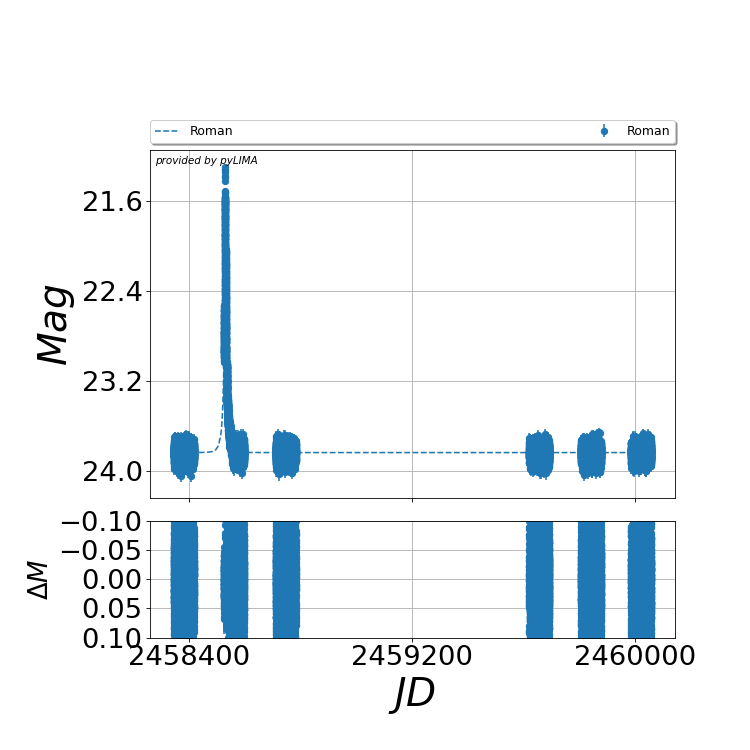

In [9]:
pyLIMA_plots.plot_lightcurves(pspl, fit1.fit_results['best_model'])
plt.show()


In [10]:
def flux_to_mag(flux):

    ZP_pyLIMA = 27.4
    magnitude = ZP_pyLIMA - 2.5 * np.log10(flux)
    return magnitude

def fluxerror_to_magerror(flux, flux_error):

    mag_err = (2.5 / np.log(10.0)) * flux_error / flux
    return mag_err

def mag_to_flux(mag):

    ZP_pyLIMA = 27.4
    flux = 10**((mag - ZP_pyLIMA) / -2.5)

    return flux

In [52]:
def gather_model_parameters(pevent, model_fit):
    """
    Function to gather the parameters of a PyLIMA fitted model into a dictionary for easier handling.
    """

    # PyLIMA model objects store the fitted values of the model parameters in the fit_results attribute,
    # which is a list of the values pertaining to the model used for the fit.  Since this model can have a
    # variable number of parameters depending on which type of model is used, we use the fit object's built-in
    # list of key indices
    param_keys = list(model_fit.fit_parameters.keys())

    model_params = {}

    for i, key in enumerate(param_keys):
        if key in ['t0' 'tE']:
            ndp = 3
        else:
            ndp = 5
        model_params[key] = np.around(model_fit.fit_results["best_model"][i], ndp)
        model_params[key+'_error'] = np.around(np.sqrt(model_fit.fit_results["covariance_matrix"][i,i]), ndp)

    # model_params['chi2'] = np.around(model_fit.fit_results["best_model"][-1], 3)
    # Reporting actual chi2 instead value of the loss function
    (chi2, pyLIMA_parameters) = model_fit.model_chi2(model_fit.fit_results["best_model"])
    model_params['chi2'] = np.around(chi2, 3)

    # If the model did not include parallax, zero those parameters
    if 'piEN' not in param_keys:
        model_params['piEN'] = 0.0
        model_params['piEN_error'] = 0.0
        model_params['piEE'] = 0.0
        model_params['piEE_error'] = 0.0

    # Calculate the reduced chi2
    ndata = 0
    for i,tel in enumerate(pevent.telescopes):
        ndata += len(tel.lightcurve)
    model_params['red_chi2'] = np.around(model_params['chi2'] / float(ndata - len(param_keys)),3)

    # Retrieve the flux parameters, converting from PyLIMA's key nomenclature to MOPs
    key_map = {
        'fsource_Tel_0': 'source_magnitude',
        'fblend_Tel_0': 'blend_magnitude'
    }

    flux_index = []
    for pylima_key,mop_key in key_map.items():
        try:
            idx = param_keys.index(pylima_key)
            model_params[mop_key] = np.around(flux_to_mag(model_fit.fit_results["best_model"][idx]), 3)
            flux_index.append(idx)
        except ValueError:
            model_params[mop_key] = np.nan

    # Retrieve the flux uncertainties and convert to magnitudes
    model_params['source_mag_error'] = np.around(
                                                fluxerror_to_magerror(model_params['fsource_Roman'],
                                                             model_params['fsource_Roman_error']),
                                                3)
    if 'fblend_Tel_0' in model_params.keys():
        model_params['blend_mag_error'] = np.around(
                                                fluxerror_to_magerror(model_params['fblend_Roman'],
                                                             model_params['fblend_Roman_error']),
                                                3)
    else:
        model_params['blend_mag_error'] = np.nan

    # If the model fitted contains valid entries for both source and blend flux,
    # use these to calculate the baseline magnitude.  Otherwise, use the source magnitude
    if not np.isnan(model_params['source_magnitude']) \
           and not np.isnan(model_params['blend_magnitude']):
        unlensed_flux = model_fit.fit_results["best_model"][flux_index[0]] \
                            + model_fit.fit_results["best_model"][flux_index[1]]
        unlensed_flux_error = np.sqrt(
                                (model_params['fsource_Roman_error']**2 + model_params['fblend_Roman_error']**2)
                                + (model_params['fsource_Roman_error']*model_params['fblend_Roman_error'])
                            )
        model_params['baseline_magnitude'] = np.around(flux_to_mag(unlensed_flux), 3)
        model_params['baseline_mag_error'] = np.around(fluxerror_to_magerror(unlensed_flux,unlensed_flux_error), 3)
    else:
        model_params['baseline_magnitude'] = model_params['source_magnitude']
        model_params['baseline_mag_error'] = model_params['source_mag_error']

    model_params['fit_covariance'] = model_fit.fit_results["covariance_matrix"]

    model_params['fit_parameters'] = model_fit.fit_parameters

    # Calculate fit statistics
    # The model_fit.model_residuals returns photometric and astrometric residuals as a dictionary
    # while the photometric residuals provides a list of arrays consisting of the
    # photometric residuals, photometric errors, and error_flux
    try:
        res = model_fit.model_residuals(model_fit.fit_results['best_model'])
        sw_test = stats.normal_Shapiro_Wilk(
            (np.ravel(res[0]['photometry'][0]) / np.ravel(res[1]['photometry'][0])))
        model_params['sw_test'] = np.around(sw_test[0],3)
        ad_test = stats.normal_Anderson_Darling(
            (np.ravel(res[0]['photometry'][0]) / np.ravel(res[1]['photometry'][0])))
        model_params['ad_test'] = np.around(ad_test[0],3)
        ks_test = stats.normal_Kolmogorov_Smirnov(
            (np.ravel(res[0]['photometry'][0]) / np.ravel(res[1]['photometry'][0])))
        model_params['ks_test'] = np.around(ks_test[0],3)
        model_params['chi2_dof'] = np.sum((np.ravel(res[0]['photometry'][0]) / np.ravel(res[1]['photometry'][0])) ** 2) / (
                len(np.ravel(res[0]['photometry'][0])) - 5)
    except:
        model_params['sw_test'] = np.nan
        model_params['ad_test'] = np.nan
        model_params['ks_test'] = np.nan
        model_params['chi2_dof'] = np.nan

    return model_params

In [53]:
print(tel1.lightcurve)

     time         mag    err_mag  ...      err_flux         inv_err_flux   
      JD          mag      mag    ...       W / m2             m2 / W      
-------------- --------- -------- ... ------------------ ------------------
2458346.505461 23.828597 0.046727 ... 1.1545288215203653 0.8661542105836121
2458346.515987 23.845108 0.047443 ... 1.1545284075202809 0.8661545211761571
2458346.526513 23.867028 0.048411 ...  1.154538803019227 0.8661467222971687
 2458346.53704 23.840056 0.047223 ... 1.1545343366538252 0.8661500730227648
2458346.547566 23.731872 0.042745 ... 1.1545485533511257 0.8661394075610401
2458346.558093 23.756923 0.043742 ... 1.1545297179645162 0.8661535380510096
2458346.568619 23.765628 0.044094 ... 1.1545266914157297 0.8661558086402987
2458346.579145 23.862608 0.048214 ... 1.1545311197401584 0.8661524864094287
2458346.589672 23.865552 0.048345 ... 1.1545332491780402 0.8661508888652113
           ...       ...      ... ...                ...                ...
2460059.1467

In [54]:
model_params = gather_model_parameters(e, fit1)
print(model_params)

{'t0': 2458530.65299, 't0_error': 0.00189, 'u0': 0.06097, 'u0_error': 0.00066, 'tE': 16.03106, 'tE_error': 0.1397, 'fsource_Roman': 11.77705, 'fsource_Roman_error': 0.12894, 'ftotal_Roman': 26.60261, 'ftotal_Roman_error': 0.00728, 'chi2': 53503.94, 'piEN': 0.0, 'piEN_error': 0.0, 'piEE': 0.0, 'piEE_error': 0.0, 'red_chi2': 1.387, 'source_magnitude': nan, 'blend_magnitude': nan, 'source_mag_error': 0.012, 'blend_mag_error': nan, 'baseline_magnitude': nan, 'baseline_mag_error': 0.012, 'fit_covariance': array([[ 3.55426563e-06,  7.00673577e-08, -1.74513708e-05,
         1.44019851e-05,  9.31077790e-08],
       [ 7.00673577e-08,  4.35176051e-07, -9.00746261e-05,
         8.44161766e-05,  1.03039206e-06],
       [-1.74513708e-05, -9.00746261e-05,  1.95149964e-02,
        -1.78461210e-02, -2.43126228e-04],
       [ 1.44019851e-05,  8.44161766e-05, -1.78461210e-02,
         1.66242489e-02,  2.04285919e-04],
       [ 9.31077790e-08,  1.03039206e-06, -2.43126228e-04,
         2.04285919e-04,  5

In [61]:
def generate_model_lightcurve(pevent, model_params):
    """Function to generate a photometric timeseries corresponding to the given model parameters"""

    pyLIMA_plots.list_of_fake_telescopes = []

    # This doesn't include parallax right now, since none of the fitted models do either yet
    pspl = PSPL_model.PSPLmodel(pevent, parallax=['None', 0.])

    params = []
    #parameters = ['t0', 'u0', 'tE', 'source_magnitude', 'blend_magnitude']
    parameters = ['t0', 'u0', 'tE', 'fsource_Roman', 'ftotal_Roman']
    for key in parameters:
        value = model_params[key]
        params.append(value)
    
    pyLIMA_parameters = pspl.compute_pyLIMA_parameters(params)
    print(pyLIMA_parameters)
    
    model_telescope = pyLIMA_plots.create_telescopes_to_plot_model(pspl, pyLIMA_parameters)[0]

    flux_model = pspl.compute_the_microlensing_model(model_telescope, pyLIMA_parameters)['photometry']

    magnitude = toolbox.brightness_transformation.flux_to_magnitude(flux_model)

    model_telescope.lightcurve["mag"] = magnitude * unit.mag

    mask = ~np.isnan(magnitude)
    model_telescope.lightcurve = model_telescope.lightcurve[mask]

    return model_telescope


In [62]:
model_telescope = generate_model_lightcurve(e,model_params)
print(model_telescope.lightcurve)

OrderedDict({'t0': 2458530.65299, 'u0': 0.06097, 'tE': 16.03106, 'fsource_Roman': 11.77705, 'ftotal_Roman': 26.60261})
     time             mag         ...      err_flux          inv_err_flux     
      JD              mag         ...       W / m2              m2 / W        
-------------- ------------------ ... ----------------- ----------------------
2458346.505461 23.837635798375935 ... 8399930253.399603 1.1904860752805442e-10
    2458346.51  23.83763579317094 ... 8399930253.399603 1.1904860752805442e-10
2458346.515987 23.837635786304524 ... 8399930253.399603 1.1904860752805442e-10
2458346.526513 23.837635774229724 ... 8399930253.399603 1.1904860752805442e-10
 2458346.53704 23.837635762150388 ... 8399930253.399603 1.1904860752805442e-10
2458346.547566 23.837635750068806 ... 8399930253.399603 1.1904860752805442e-10
2458346.558093 23.837635737982684 ... 8399930253.399603 1.1904860752805442e-10
2458346.568619 23.837635725894316 ... 8399930253.399603 1.1904860752805442e-10
2458346.5791

In [66]:
with open(path.join(data_dir, lc_file.replace('.txt', '_model.txt')), 'w') as f:
    f.write('# JD    mag\n')
    for row in model_telescope.lightcurve:
        f.write(str(row['time'].value) + '  ' + str(row['mag'].value) + '\n')